In [1]:
# Importing necessary libraries for data cleaning and exploration

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from Utils.preprocessing import *
from Utils.customPipelines import *

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE=632

In [2]:
# We want to difference the data to find the n-day returns
def get_differenced_data(df_temp, p=1):
    df_diff = df_temp[[col for col in df_temp.columns if col != 'Date']].diff(periods=p)
    df_diff["Date"] = df_temp["Date"]
    return df_diff.dropna().reset_index(drop=True)


In [3]:
# Load the dataset
df = pd.read_csv('data\\QF632_Project_1.csv')

# Change date format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# We set our forecast horizon early to compare runs between horizons
h = 1

# 1. Review the quality of the data, 
List any potential errors, and propose corrected values. Please list each quality check errorand correction applied.

- Check row types are consistent (all float64)
- Remove duplicates
- Forward fill NaN values
- Check date format and sequence is correct
- Forward fill negative values in signal & ETF prices

In [4]:
# Examine the structure and summary
print(df.info())
print(df.describe())
print()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print()

# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
print()

# Ensure dates are in the right format and sequence
date_check = df['Date'].apply(pd.to_datetime, errors='coerce').isnull().sum()
print(f"Invalid dates: {date_check}")

# Check for date sequence issues
date_order_issues = (df['Date'] != df['Date'].sort_values()).any()
if date_order_issues:
    print("Dates are out of order")
else:
    print("Dates are in correct order")
print()

# Ensure prices and signals are non-zero and positive
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
value_check = {col: (df[col] < 0).sum() for col in columns_to_check}

print(f"Negative/zero values: {value_check}")
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB
None
            Signal         Open         High          Low        Close  \
count  1038.000000  1038.000000  1038.000000  1038.000000  1038.000000   
mean     16.766190   141.847360   142.691801   140.907746   141.840973   
std       3.095783    18.475574    18.470255    18.404504    18.497010   
min       0.000000    94.080002    95.400002    93.639999    94.790001   
25%      14.691150   132.132496   13

In [5]:
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
# Correcting negative/zero historical prices and signal values using forward fill
for col in columns_to_check:
    # Replace zero and negative values with NaN
    df[col] = df[col].mask(df[col] <= 0)
    
    # Forward fill NaN values
    df[col].fillna(method='ffill', inplace=True)

In [6]:
df_diff = get_differenced_data(df.copy(), h)

# 2. Run any exploratory data analysis you think is important and highlight any interesting insights you come across

## 2a(i). Visualising the data

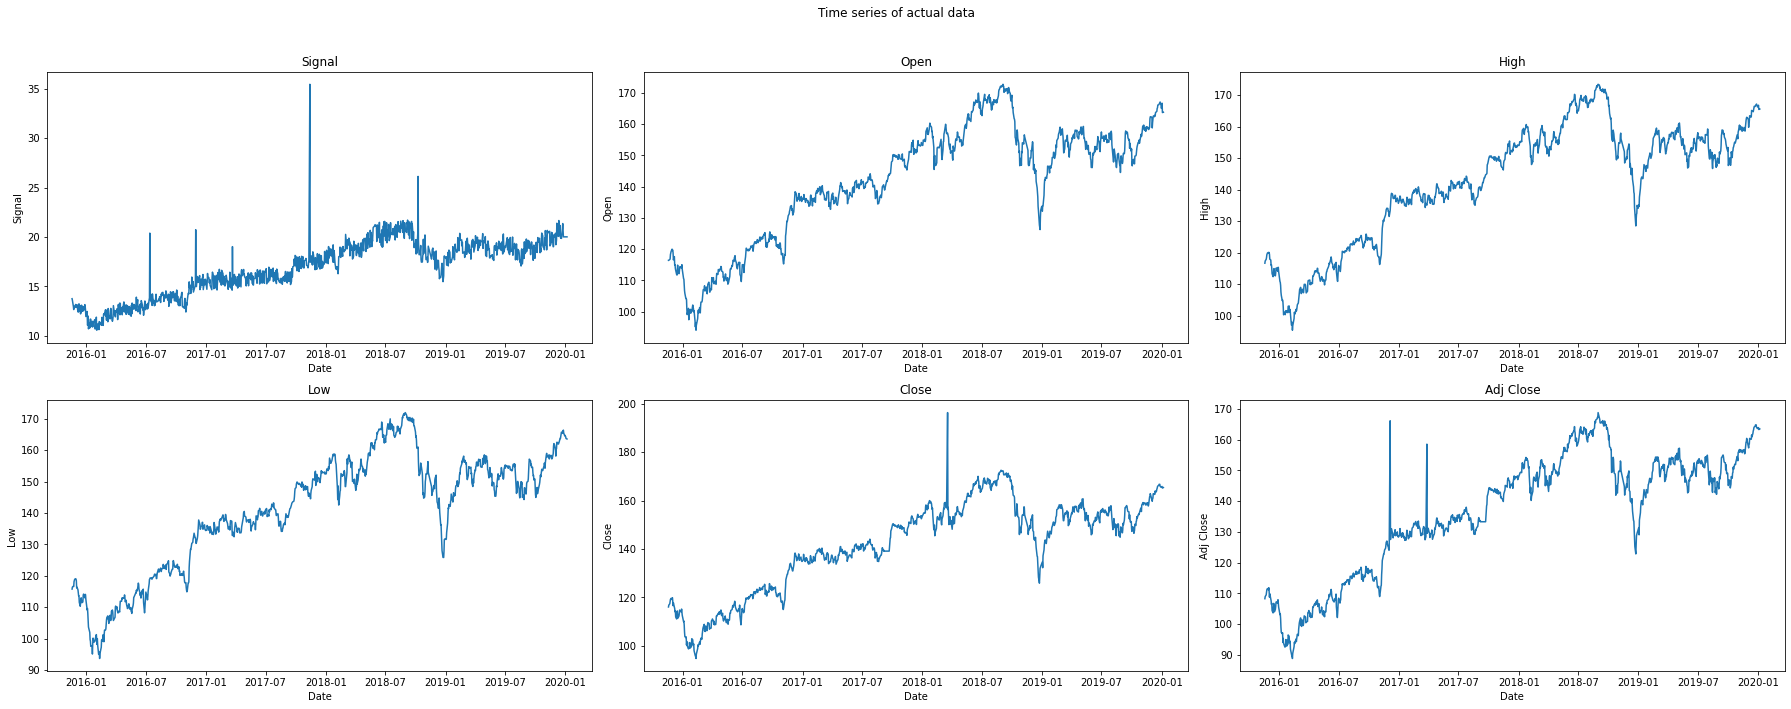

In [7]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Time series of actual data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df.Date, y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- 2016 - end 2018: There is an upward trend. Prices of ETF seems to be additive as it's variance is rather constant. Some outliers present in the close and Adjusted Close price. 4 points of outliers in signal.
- End 2018 - mid 2019: There is a sharp dip followed by a prompt recovery of similar steepness.
- Mid 2019 - End of data: No trend observed. We can observe something akin to quarterly seasonality. Unclear if the final rise in 2020 is as a result of increasing trend or quarterly seasonality.

## 2a(ii). Visualising differenced data

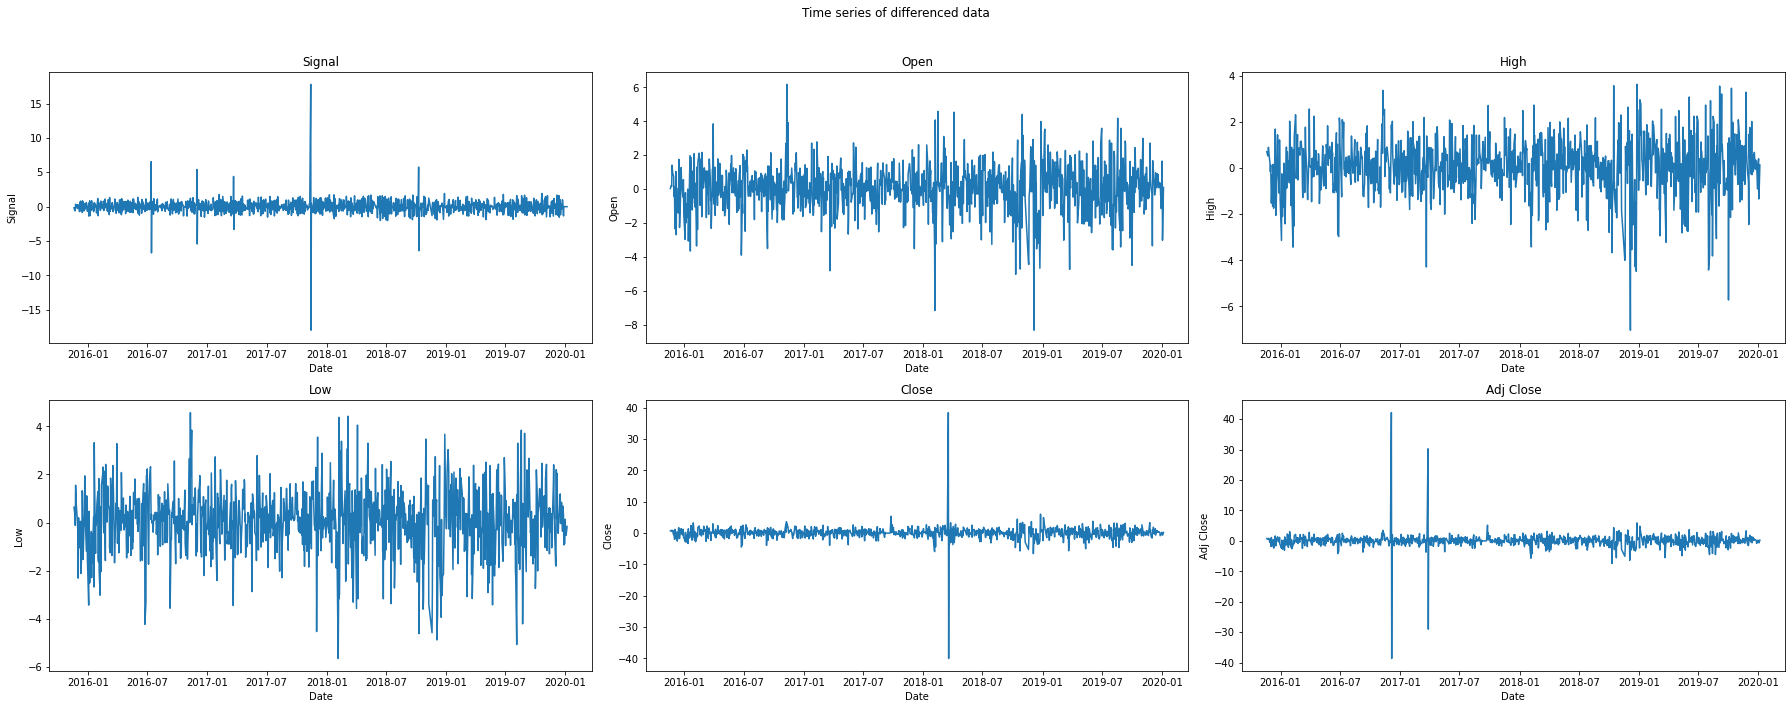

In [8]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Time series of differenced data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_diff.Date, y=df_diff[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 2b. Time Series Decomposition

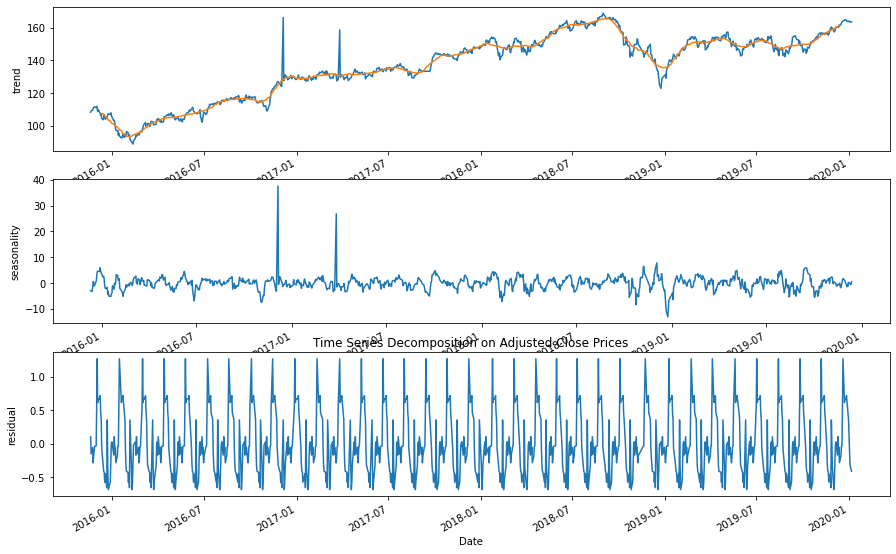

In [9]:
df_decomp = df.copy()
df_decomp.index = df_decomp.Date

res = seasonal_decompose(df_decomp["Adj Close"], model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10))
res.observed.plot(ax=ax1,ylabel = "trend")
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasonality")
res.seasonal.plot(ax=ax3,ylabel = "residual")

plt.title("Time Series Decomposition on Adjusted Close Prices")
plt.show()

We decompose the adjusted close data as it is the most representative of ETF prices, using the additive method. From the plots above, we can determine that there is still time-series information left in the residuals after decomposition as we see a clear pattern there. The trend in general goes upwards, and there doesn't seem to be any strong seasonality in this set of data.


## 2c. ACF/PACF

Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. In other words, it measures the relationship between a variable’s current value and its past values.

PACF measures the relationship between a variable’s current value and its past values unconditional to the preceeding lags.


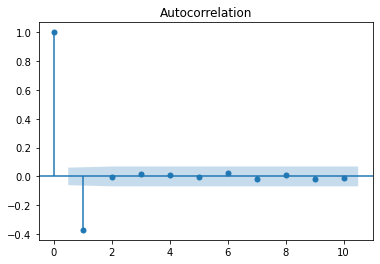

In [10]:
sm.graphics.tsa.plot_acf(df_diff["Adj Close"].dropna(), lags=10)
plt.show()

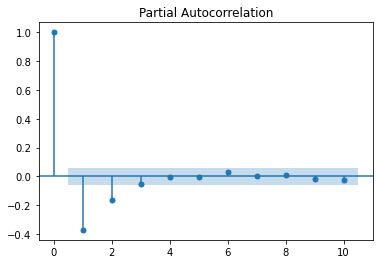

In [11]:
sm.graphics.tsa.plot_pacf(df_diff["Adj Close"].dropna(), lags=10)
plt.show()

ACF is significant at lag 1, whereas PACF is shows a geometric decay at each m lag. This can signify a moving average (MA) component in an ARIMA model if used.  

## 2d(i). Outlier Detection - Boxplots

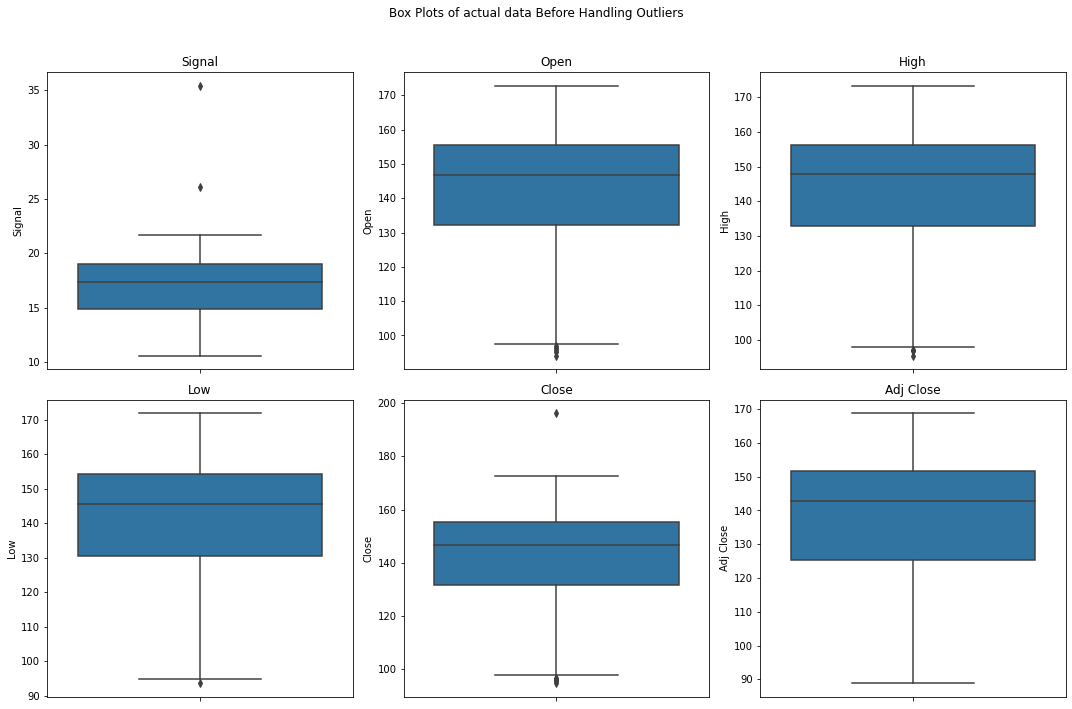

In [12]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots of actual data Before Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Extreme high outliers:
- Signal has 2 points 
- Close has 1 oint

Extreme low points:
- All columns except Adj Close

This is interesting as this means that after removing all volatility from day to day trades as well as taking into account corporate actions such as stock splits, dividends, and mergers, the actual price of ETF does not seem to have any outliers.

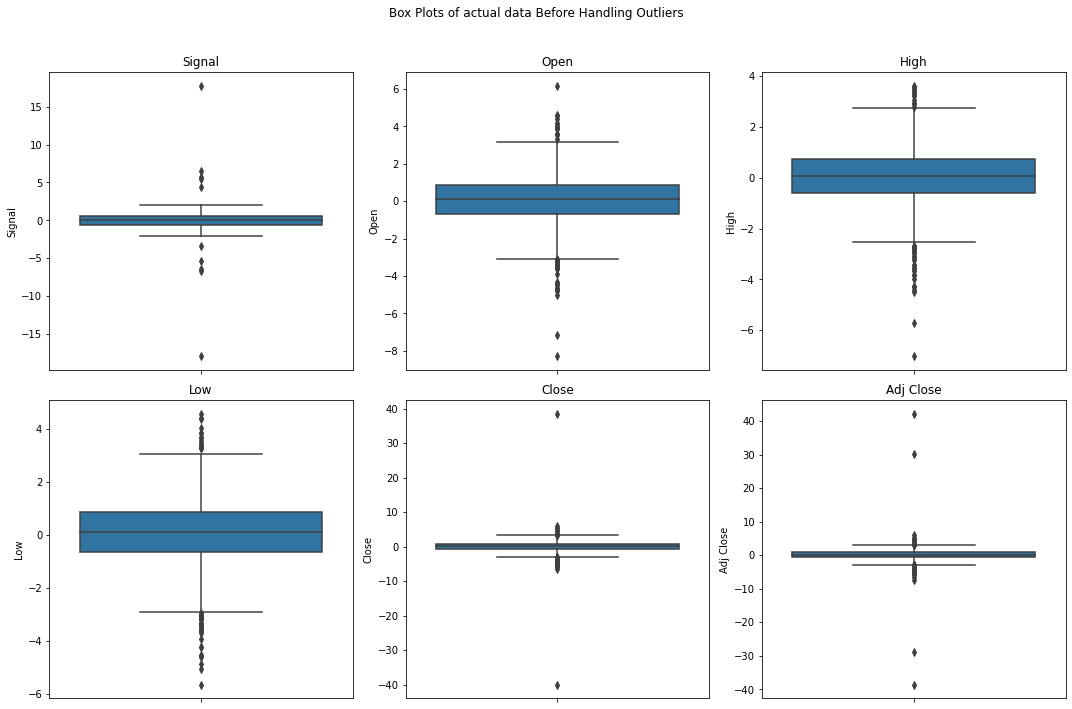

In [13]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots of actual data Before Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_diff[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

After differencing the data by 1 period, we see that outliers are more apparent in all columns

Rate of change of all prices seem to be normally distributed with a mean of 0. The kurtosis of signal, close and adjusted close returns of ETF are significantly higher than the rest of the columns.

## 2d(ii). Outlier handling


In [14]:
# Function to handle large increases by forward filling
def handle_large_increases_ffill(differences, columns, multiplier):
    # Identify data points with increases more than mean +/- threshold * std 
    for col in columns:
        large_increases = []
        col_diff = differences[col]
        for i in range(len(differences)//10, len(differences)):
            avg_movement = col_diff[:i-1].abs().mean()
            std_movement = col_diff[:i-1].abs().std()
            threshold = avg_movement + std_movement * multiplier
            if abs(col_diff[i]) > threshold:
                # Replace data points with large increases with NaN
                differences.at[i, col] = float('nan')
                large_increases.append(i)
    
        # Forward fill NaN values
        differences[col].fillna(method='ffill', inplace=True)
    
        print(f"% of data points with increases more than {multiplier} times the average move in {col}: {len(large_increases)/len(differences)}")
    return differences

df_diff_outliers_imputed = handle_large_increases_ffill(df_diff.copy(), columns_to_check, 3)

% of data points with increases more than 3 times the average move in Signal: 0.01639344262295082
% of data points with increases more than 3 times the average move in Open: 0.04339440694310511
% of data points with increases more than 3 times the average move in High: 0.037608486017357765
% of data points with increases more than 3 times the average move in Low: 0.04725168756027001
% of data points with increases more than 3 times the average move in Close: 0.044358727097396335
% of data points with increases more than 3 times the average move in Adj Close: 0.05014464802314368


### - Boxplot after outlier handling

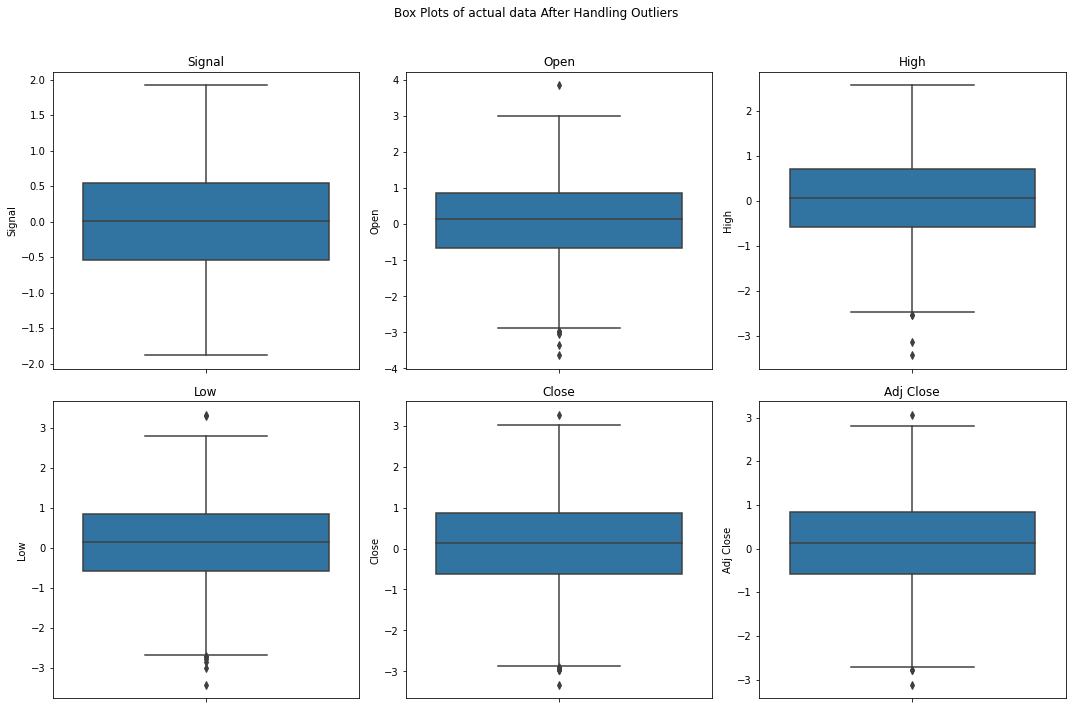

In [15]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots of actual data After Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_diff_outliers_imputed[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### - Line graphs before outlier handling

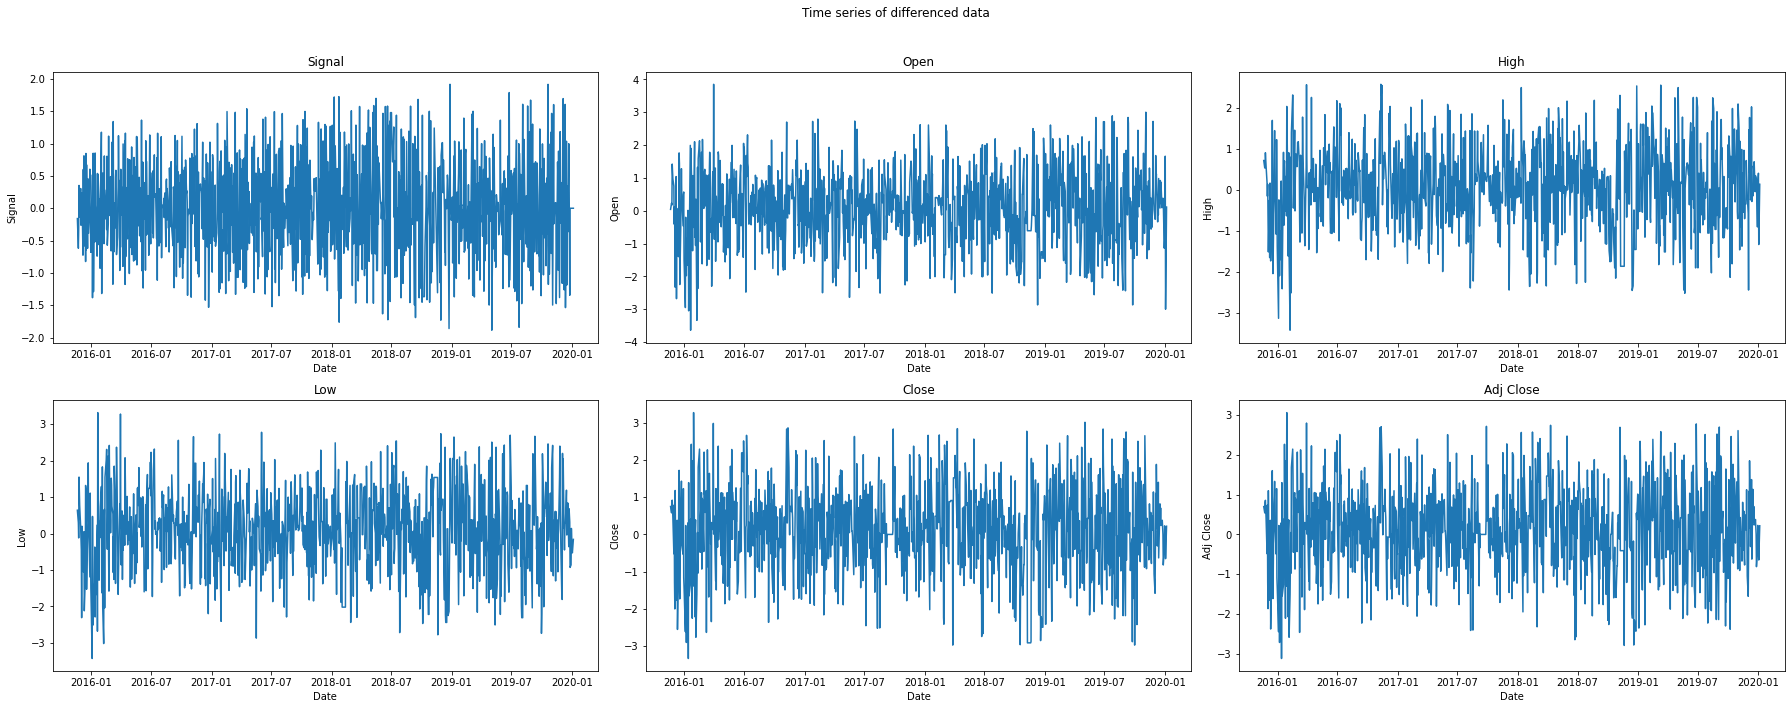

In [16]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Time series of differenced data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_diff_outliers_imputed.Date, y=df_diff_outliers_imputed[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

After differencing the data, the plots indicates that the data have a constant location and variance, hence the differenced data can be considered to be stationary.

## 2e. Other interesting exploratory data analysis
Looking at volatility as a predictor of fuutre ETF prices.

Here we define volatility as the std of the difference between the high and low prices of the past 20 days

### 2e(i). Cross-correlation between Signal and ETF prices before outlier handling


We want to observe the correlation between signal and ETF prices to evaluate how well the signal's pattern matches ETF prices. Additionally, we also want to analyse if the signal columns actually matches farther horizons of ETF prices better.

In [17]:
horizons = 10
lags = ["Lag"+str(i) for i in range(horizons+1)]
etf_prices = ["Open", "High", "Low", "Close", "Adj Close"]

df_cross_corr = pd.DataFrame()
df_cross_corr["Lag_no"] = lags

for etf in etf_prices:
    collated_corr = []
    for horizon in range(horizons+1):
        # df_diff_temp = get_differenced_data(df.copy(), horizon)
        df_lagged = df_diff.copy()
        if horizon != 0:
            df_lagged["Signal"] = df_diff["Signal"].shift(horizon)
            df_lagged = df_lagged.dropna()
        collated_corr.append(abs(np.corrcoef(df_lagged["Signal"], df_lagged[etf])[0][1]))
    df_cross_corr["Signal-"+etf] = collated_corr

df_cross_corr


,Lag_no,Signal-Open,Signal-High,Signal-Low,Signal-Close,Signal-Adj Close
0,Lag0,0.003330,0.022198,0.011773,0.005776,0.023589
1,Lag1,0.027416,0.020841,0.017287,0.015307,0.025731
2,Lag2,0.050550,0.049524,0.013156,0.052106,0.102704
3,Lag3,0.029420,0.064496,0.038021,0.062016,0.231563
4,Lag4,0.024686,0.002555,0.026192,0.014621,0.116024
5,Lag5,0.005892,0.007958,0.017439,0.027300,0.025175
6,Lag6,0.037767,0.063929,0.073099,0.045887,0.036378
7,Lag7,0.075552,0.062230,0.058901,0.021834,0.002521
8,Lag8,0.025402,0.001746,0.012340,0.007456,0.002803
9,Lag9,0.032741,0.035765,0.015158,0.027273,0.012821


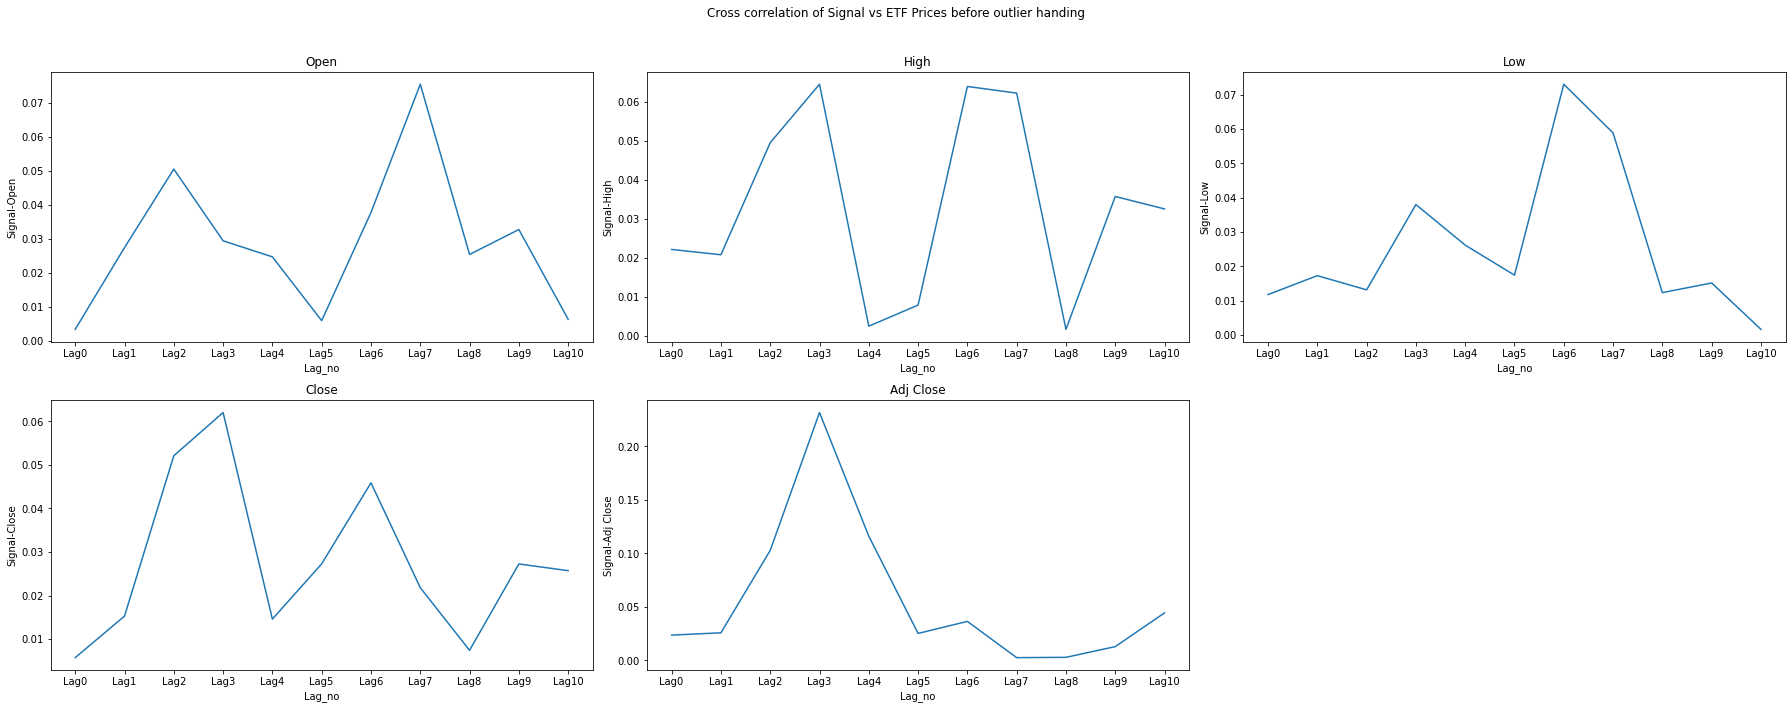

In [18]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Cross correlation of Signal vs ETF Prices before outlier handing')

for i, col in enumerate(etf_prices, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_cross_corr.Lag_no, y=df_cross_corr["Signal-"+col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

From the above graph, we can see that the rate of change of signal has the highest correlation with adjusted close ETF returns at lag 3. This can mean that the signal from 3 time lags ago is the best at predicting today's adjusted close ETF. However even so, the maximum correlation between the signal and the adjusted close ETF returns is at 0.3, which is low. Hence, it can be inferred here that signal may not be a good predictor of adjusted close ETF returns.


### 2e(ii). Cross-correlation between Signal and ETF prices after outlier handling

In [19]:
# With outliers
df_cross_corr_outliers = pd.DataFrame()
df_cross_corr_outliers["Lag_no"] = lags

for etf in etf_prices:
    collated_corr = []
    for horizon in range(horizons+1):
        # df_diff_temp = get_differenced_data(df.copy(), horizon)
        df_lagged = df_diff_outliers_imputed.copy()
        if horizon != 0:
            df_lagged["Signal"] = df_diff["Signal"].shift(horizon)
            df_lagged = df_lagged.dropna()
        collated_corr.append(abs(np.corrcoef(df_lagged["Signal"], df_lagged[etf])[0][1]))
    df_cross_corr_outliers["Signal-"+etf] = collated_corr

df_cross_corr_outliers


,Lag_no,Signal-Open,Signal-High,Signal-Low,Signal-Close,Signal-Adj Close
0,Lag0,0.004207,0.009890,0.012193,0.011375,0.003295
1,Lag1,0.003036,0.003223,0.007116,0.002466,0.007742
2,Lag2,0.025764,0.040680,0.004794,0.006661,0.010620
3,Lag3,0.050260,0.074150,0.037610,0.060612,0.059237
4,Lag4,0.008409,0.017284,0.009523,0.006596,0.018535
5,Lag5,0.005308,0.022586,0.022068,0.020839,0.022925
6,Lag6,0.015062,0.049467,0.071888,0.105928,0.093526
7,Lag7,0.062141,0.073534,0.047015,0.018866,0.030330
8,Lag8,0.045410,0.000604,0.019053,0.006578,0.009827
9,Lag9,0.035267,0.038117,0.009097,0.036812,0.033001


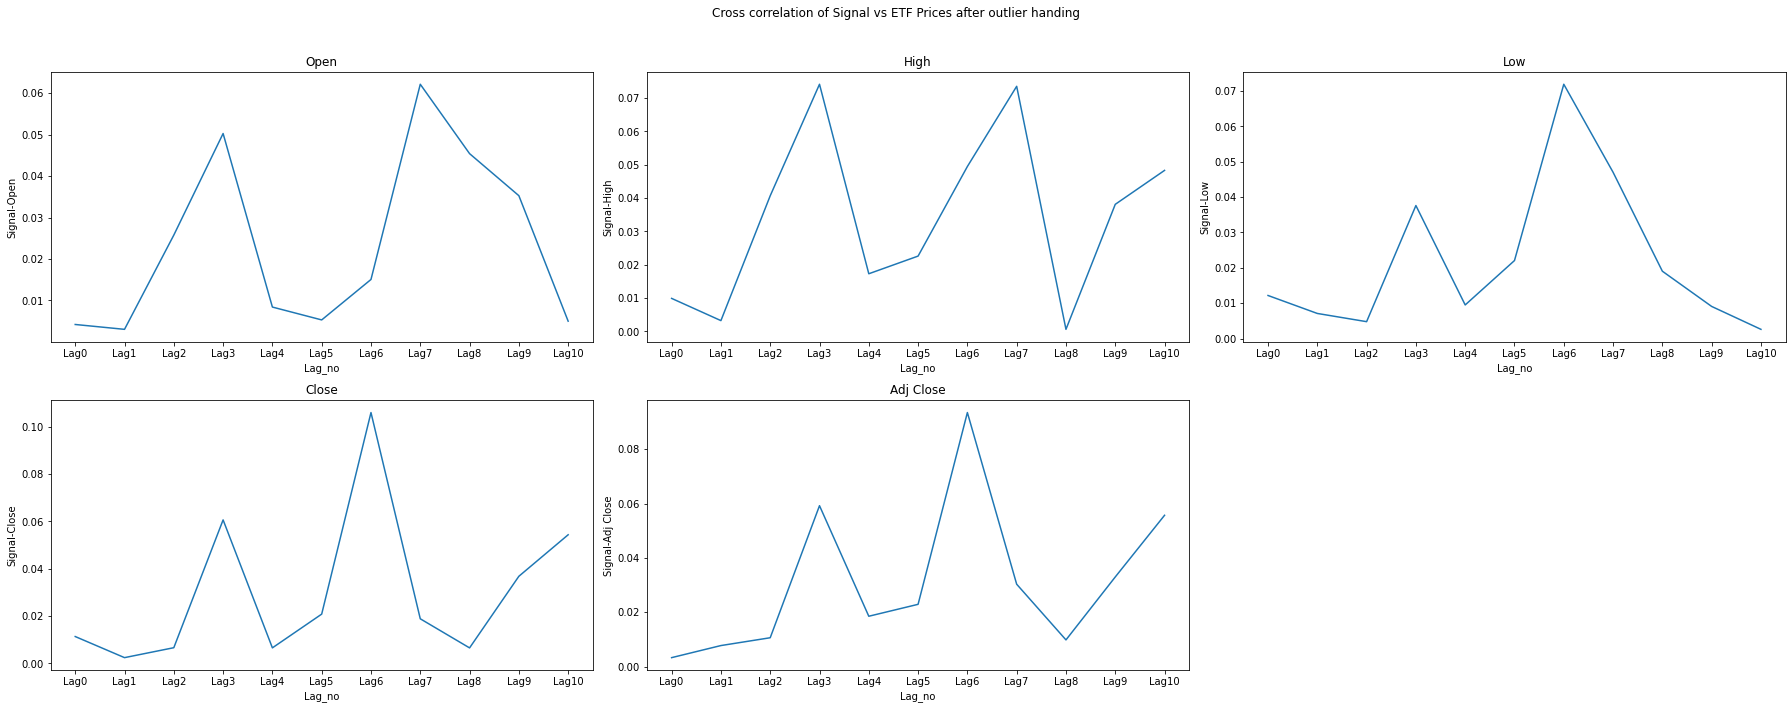

In [20]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Cross correlation of Signal vs ETF Prices after outlier handing')

for i, col in enumerate(etf_prices, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_cross_corr_outliers.Lag_no, y=df_cross_corr_outliers["Signal-"+col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 3. Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price

## 3a. Evaluate against Baseline: Naive

For our baseline model, we used naive, which is taking the lag of price as next horizon forecast, essentially forecasting change in price to be 0. This is an important baseline model to beat as if naive performs better than signal, it would mean that the time series data might not have strong patterns or that the complexity of the model is unnecessary for capturing the underlying dynamics of the data. 

We also used differenced data for our training and forecasting in order to ensure that stationarity is present.

To ensure fair test between Signal and Naive, we also quantify the percentage of times Signal as a predictor outperforms Naive, as outlier prediction can drive up MAE unfairly. 

In [21]:
# Returns the % of wins Signal has against the baseline
def perc_beat_baseline(model_pred, baseline, y_test):
    score_df = pd.DataFrame()
    score_df["model vs baseline"] = (baseline - y_test).abs() - (model_pred - y_test).abs()

    return len(score_df[score_df["model vs baseline"] > 0])/len(score_df)

In [22]:
test_size = len(df_diff[df_diff["Date"] >= "2016-01-01"].copy())
test_sets = df_diff.iloc[-test_size:,:].copy()
print(test_sets.shape)

(1009, 7)


## 3b(i) Before outlier handling

In [23]:
models_performance_mae = pd.DataFrame()
models_performance_mae["Prices"] = etf_prices

models_performance_pw = pd.DataFrame()
models_performance_pw["Prices"] = etf_prices

naive_pred_all = df_diff[["Date"] + etf_prices].copy()[-len(test_sets):]

naive_mae = []
naive_dir_score = []
for etf in etf_prices:
    naive_pred_all[etf] = 0
    naive_pred = naive_pred_all[etf]
    mae = format(mean_absolute_error(naive_pred, test_sets[etf]), ".2f")  
    std = format(np.std(naive_pred), ".2f")  

    naive_mae.append(str(mae) + " (" + str(std) + ")")
    naive_dir_score.append(dir)

models_performance_mae["Naive"] = naive_mae

In [24]:
# Vs Signal
signal_mae = []
signal_pw = []
# Adjust dataset for fair test
signal_pred = df_diff[["Date", "Signal"]][-len(test_sets):].copy()
for etf in etf_prices:
    mae = format(mean_absolute_error(signal_pred["Signal"], test_sets[etf]), ".2f")  
    perc_win = format(perc_beat_baseline(signal_pred["Signal"], naive_pred_all[etf], test_sets[etf]), ".2f")
    std = format(np.std(signal_pred["Signal"]), ".2f")  

    signal_mae.append(str(mae) + " (" + str(std) + ")")
    signal_pw.append(perc_win)

models_performance_mae["Signal"] = signal_mae
models_performance_pw["Signal"] = signal_pw

In [25]:
# Vs Signal at best lag
signal_mae = []
signal_pw = []
# Adjust dataset for fair test
signal_pred_lag = df_diff[["Signal"]].shift(3).copy()[-len(test_sets):]
signal_pred_lag["Date"] = df_diff["Date"].copy()[-len(test_sets):]

for etf in etf_prices:
    mae = format(mean_absolute_error(signal_pred_lag["Signal"], test_sets[etf]), ".2f")  
    perc_win = format(perc_beat_baseline(signal_pred_lag["Signal"], naive_pred_all[etf], test_sets[etf]), ".2f")
    std = format(np.std(signal_pred_lag["Signal"]), ".2f")  

    signal_mae.append(str(mae) + " (" + str(std) + ")")
    signal_pw.append(perc_win)

models_performance_mae["Signal at lag 3"] = signal_mae
models_performance_pw["Signal at lag 3"] = signal_pw

## 3b(ii) After outlier handling

In [26]:
# Vs Signal
signal_mae = []
signal_pw = []
# Adjust dataset for fair test
signal_pred_outlier = df_diff_outliers_imputed[["Date", "Signal"]][-len(test_sets):]

for etf in etf_prices:
    mae = format(mean_absolute_error(signal_pred_outlier["Signal"], test_sets[etf]), ".2f")  
    perc_win = format(perc_beat_baseline(signal_pred_outlier["Signal"], naive_pred_all[etf], test_sets[etf]), ".2f")
    std = format(np.std(signal_pred_outlier["Signal"]), ".2f")  

    signal_mae.append(str(mae) + " (" + str(std) + ")")
    signal_pw.append(perc_win)

models_performance_mae["Signal (Outlier Handling)"] = signal_mae
models_performance_pw["Signal (Outlier Handling)"] = signal_pw

In [27]:
# Vs Signal
signal_mae = []
signal_pw = []
# Adjust dataset for fair test
signal_pred_outlier_lag = df_diff_outliers_imputed[["Signal"]].shift(6).copy()[-len(test_sets):]
signal_pred_outlier_lag["Date"] = df_diff_outliers_imputed["Date"].copy()[-len(test_sets):]

for etf in etf_prices:
    mae = format(mean_absolute_error(signal_pred_outlier_lag["Signal"], test_sets[etf]), ".2f")  
    perc_win = format(perc_beat_baseline(signal_pred_outlier_lag["Signal"], naive_pred_all[etf], test_sets[etf]), ".2f")
    std = format(np.std(signal_pred_outlier_lag["Signal"]), ".2f")  

    signal_mae.append(str(mae) + " (" + str(std) + ")")
    signal_pw.append(perc_win)

models_performance_mae["Signal at lag 6 (Outlier Handling)"] = signal_mae
models_performance_pw["Signal at lag 6 (Outlier Handling)"] = signal_pw
models_performance_mae

,Prices,Naive,Signal,Signal at lag 3,Signal (Outlier Handling),Signal at lag 6 (Outlier Handling)
0,Open,1.05 (0.00),1.30 (1.22),1.27 (1.22),1.22 (0.77),1.22 (0.77)
1,High,0.89 (0.00),1.20 (1.22),1.12 (1.22),1.12 (0.77),1.07 (0.77)
2,Low,1.01 (0.00),1.27 (1.22),1.24 (1.22),1.20 (0.77),1.15 (0.77)
3,Close,1.13 (0.00),1.40 (1.22),1.35 (1.22),1.32 (0.77),1.26 (0.77)
4,Adj Close,1.15 (0.00),1.43 (1.22),1.36 (1.22),1.34 (0.77),1.28 (0.77)


In [28]:
models_performance_pw

,Prices,Signal,Signal at lag 3,Signal (Outlier Handling),Signal at lag 6 (Outlier Handling)
0,Open,0.38,0.41,0.39,0.40
1,High,0.35,0.42,0.35,0.40
2,Low,0.37,0.40,0.37,0.42
3,Close,0.37,0.43,0.37,0.43
4,Adj Close,0.37,0.42,0.37,0.43


## 3c. Performance of Signal against Naive by Year

To ensure that the high MAE of the Signal is not as a result of the underperformance of outlier time periods, we are also interested in monitoring the change in metrics over the years, and evaluate if Signal as a predictor consistently underperforms Naive.

In [29]:
forecast_years = test_sets['Date'].dt.year.unique().tolist()
forecasts = [naive_pred_all, signal_pred, signal_pred_lag, signal_pred_outlier, signal_pred_outlier_lag]
model_names = models_performance_mae.columns.to_list()[1:]

models_performance_mae_by_year = pd.DataFrame()
models_performance_mae_by_year["Year"] = forecast_years

models_performance_pw_by_year = pd.DataFrame()
models_performance_pw_by_year["Year"] = forecast_years

for i, model in enumerate(forecasts):
    mae = []
    pw = []
    year_counts_all = []
    
    for year in forecast_years:
        model_by_year = model[model["Date"].dt.year==year].copy()

        test_set_by_year = test_sets[test_sets["Date"].dt.year==year].copy()
        if ("naive" in model_names[i].lower()) or ("arima" in model_names[i].lower()):
            pred = model_by_year["Adj Close"]
        else:
            pred = model_by_year["Signal"]

        naive_by_year = forecasts[0][forecasts[0]["Date"].dt.year==year].copy()
        pw.append(format(perc_beat_baseline(pred, naive_by_year["Adj Close"], test_set_by_year["Adj Close"]), ".2f"))
        mae.append(mean_absolute_error(pred, test_set_by_year["Adj Close"]))

        year_counts_all.append(len(test_set_by_year))

    models_performance_mae_by_year[model_names[i]] = mae
    
    models_performance_pw_by_year[model_names[i]] = pw

models_performance_mae_by_year["Sample Count"] = year_counts_all
models_performance_pw_by_year["Sample Count"] = year_counts_all
models_performance_mae_by_year


,Year,Naive,Signal,Signal at lag 3,Signal (Outlier Handling),Signal at lag 6 (Outlier Handling),Sample Count
0,2016,1.243047,1.496629,1.328046,1.408498,1.327340,252
1,2017,0.990522,1.425036,1.288485,1.257901,1.209483,252
2,2018,1.238025,1.475460,1.529969,1.399995,1.416818,250
3,2019,1.146655,1.322327,1.295795,1.322327,1.172815,252
4,2020,0.323080,0.323080,0.323080,0.323080,1.199989,3


In [30]:
models_performance_pw_by_year

,Year,Naive,Signal,Signal at lag 3,Signal (Outlier Handling),Signal at lag 6 (Outlier Handling),Sample Count
0,2016,0.00,0.39,0.45,0.40,0.46,252
1,2017,0.00,0.31,0.41,0.31,0.35,252
2,2018,0.00,0.39,0.41,0.40,0.40,250
3,2019,0.00,0.38,0.42,0.38,0.50,252
4,2020,0.00,0.00,0.00,0.00,0.00,3


# 4. Write a summary for the team addressing your observations about the efficacy and believability of the product, and recommendation for next steps.

The product is using signal as a predictor for ETF prices. As analysed earlier, we compared the predictive power of signal with naive approach, signal does not forecast ETF prices better than naive across all time periods. Hence, the efficacy of the product can be greatly improved in terms of its predictive quality, as the value of its prediction hinges on beating the baseline.

Recommendations:
- Take into account cross correlation: Features used to build the Signal can be analysed against the ETF prices to find the lag with highest autocorrelation.
- Perhaps taking previous days' price volatility into account would help with the prediction
- Identify specific characteristics of the ETF to forecast (e.g., sector-specific ETFs, leveraged ETFs) as these can influence their price dynamics.
- Research and gather more uncorrelated features that can forecast ETF prices. 
-- I.e., Macroeconomic Indicators: interest rates, GDP growth
-- News Sentiment: Sentiment analysis of news related to the ETF or its underlying assets if applicable.

